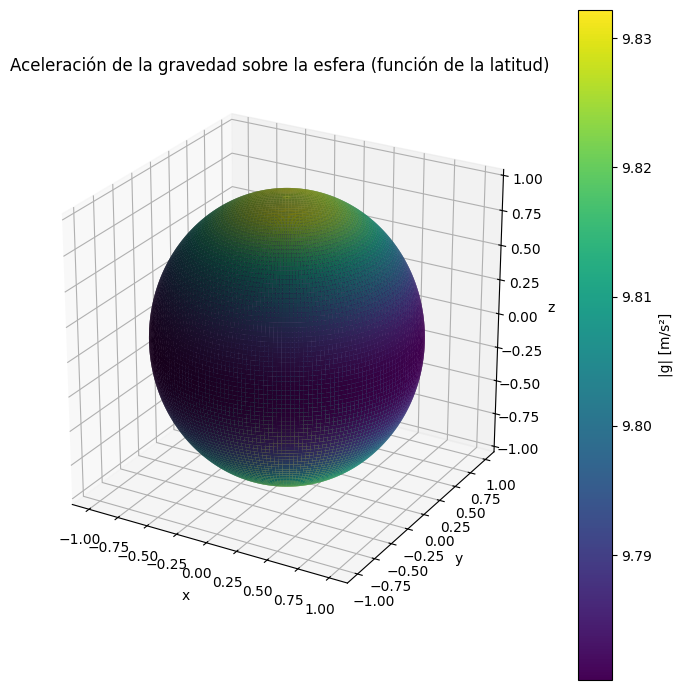

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para proyección 3d
from matplotlib.colors import Normalize

# ==============================
# 1. Parámetros y modelo de g
# ==============================
R = 1.0  # radio normalizado del planeta

# mallado en la esfera: theta = colatitud [0, π], phi = longitud [0, 2π]
theta = np.linspace(0, np.pi, 200)      # 0 = polo norte, π/2 = ecuador, π = polo sur
phi = np.linspace(0, 2*np.pi, 400)
phi_grid, theta_grid = np.meshgrid(phi, theta)

# coordenadas cartesianas de la esfera r = R
Xs = R * np.sin(theta_grid) * np.cos(phi_grid)
Ys = R * np.sin(theta_grid) * np.sin(phi_grid)
Zs = R * np.cos(theta_grid)

# g en la superficie: z/r = cos(theta)
g_sphere = 9.780327 * (1 + 0.0053024 * (np.cos(theta_grid)**2))

# normalización para el mapa de color
norm = Normalize(vmin=g_sphere.min(), vmax=g_sphere.max())
colors = plt.cm.viridis(norm(g_sphere))

# ==============================
# 2. Gráfica 3D sobre la esfera
# ==============================
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    Xs, Ys, Zs,
    facecolors=colors,
    rstride=2, cstride=2,
    linewidth=0,
    antialiased=True
)

# barra de color
mappable = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
mappable.set_array([])
fig.colorbar(mappable, ax=ax, label='|g| [m/s²]')

ax.set_title("Aceleración de la gravedad sobre la esfera (función de la latitud)")
ax.set_box_aspect([1, 1, 1])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=25, azim=-60)  # ajusta la cámara si quieres

plt.tight_layout()
plt.show()


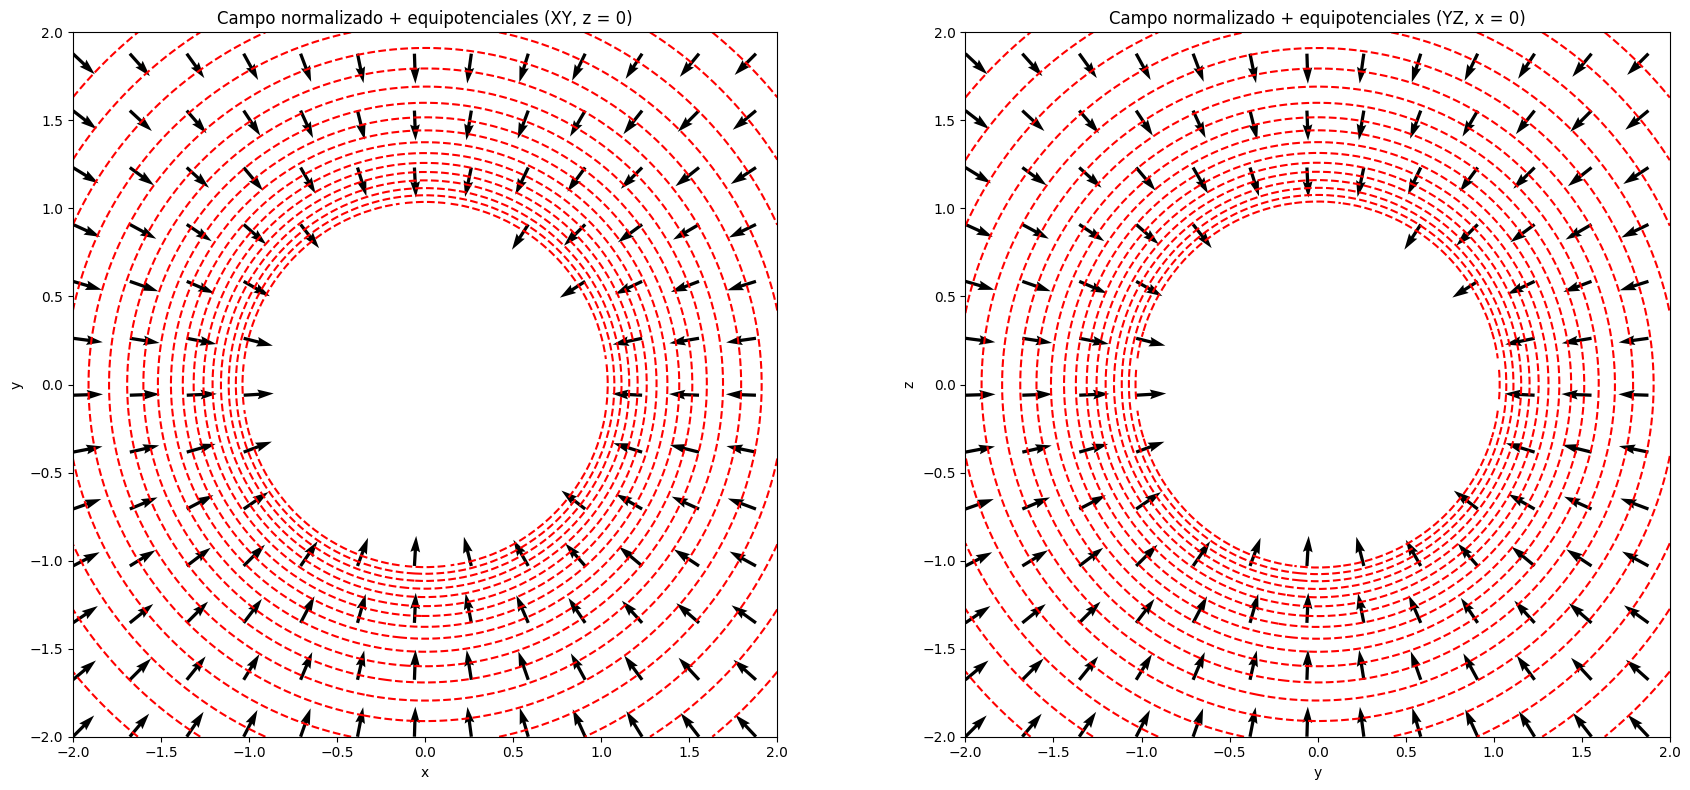

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy.integrate import quad

# Definimos variables simbólicas
x, y, z = sp.symbols('x y z', real=True)
r = sp.sqrt(x**2 + y**2 + z**2)

# Constantes
R = 1.0  # Radio de la Tierra normalizado

# Aproximación de g(phi) con sin(phi) ~ z / r
g = 9.780327 * (1 + 0.0053024 * (z / r)**2)

def g_numeric(r_val, z_val):
    return 9.780327 * (1 + 0.0053024 * (z_val / r_val)**2)

def Phi_integrated_numeric(z_val):
    integrand = lambda r_val: g_numeric(r_val, z_val)
    result, _ = quad(integrand, R, 1e3)  # acotamos para evitar divergencia
    return -result

Phi0 = Phi_integrated_numeric(0)
z_scaled = z / R
Phi_poly = Phi0 * (1 + 0.0053024 * z_scaled**2)
Phi_poly = sp.series(Phi_poly, z_scaled, 0, 5).removeO().subs(z_scaled, z / R) * R

Phi_star = Phi_poly
Phi_exterior = (1 / r) * Phi_star.subs({x: x/r**2, y: y/r**2, z: z/r**2})
Phi_exterior_simplified = sp.simplify(Phi_exterior)

g_field = -sp.Matrix([sp.diff(Phi_exterior_simplified, v) for v in (x, y, z)])

Phi_func = lambdify((x, y, z), Phi_exterior_simplified, "numpy")
g_func = lambdify((x, y, z), g_field, "numpy")

res = 100
xv = np.linspace(-2, 2, res)
yv = np.linspace(-2, 2, res)
zv = np.linspace(-2, 2, res)
xm_xy, ym_xy = np.meshgrid(xv, yv)
zm_xy = np.zeros_like(xm_xy)
r_xy = np.sqrt(xm_xy**2 + ym_xy**2)
mask_xy = r_xy >= R

Phi_xy = Phi_func(xm_xy, ym_xy, zm_xy)
Phi_xy[~mask_xy] = np.nan
gxy = g_func(xm_xy, ym_xy, zm_xy)
gx_xy = np.array(gxy[0]).reshape(xm_xy.shape)
gy_xy = np.array(gxy[1]).reshape(ym_xy.shape)
gx_xy[~mask_xy] = np.nan
gy_xy[~mask_xy] = np.nan

# Normalización del campo XY
mag_xy = np.sqrt(gx_xy**2 + gy_xy**2) + 1e-10
gx_xy_norm = gx_xy / mag_xy
gy_xy_norm = gy_xy / mag_xy

ym_yz, zm_yz = np.meshgrid(yv, zv)
xm_yz = np.zeros_like(ym_yz)
r_yz = np.sqrt(ym_yz**2 + zm_yz**2)
mask_yz = r_yz >= R

Phi_yz = Phi_func(xm_yz, ym_yz, zm_yz)
Phi_yz[~mask_yz] = np.nan
gyz = g_func(xm_yz, ym_yz, zm_yz)
gy_yz = np.array(gyz[1]).reshape(ym_yz.shape)
gz_yz = np.array(gyz[2]).reshape(zm_yz.shape)
gy_yz[~mask_yz] = np.nan
gz_yz[~mask_yz] = np.nan

# Normalización del campo YZ
mag_yz = np.sqrt(gy_yz**2 + gz_yz**2) + 1e-10
gy_yz_norm = gy_yz / mag_yz
gz_yz_norm = gz_yz / mag_yz

fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(1, 2, 1)
c1 = ax1.contour(xv, yv, Phi_xy, levels=np.linspace(np.nanmin(Phi_xy), np.nanmax(Phi_xy), 20), colors='red')
ax1.quiver(xm_xy[::8, ::8], ym_xy[::8, ::8], gx_xy_norm[::8, ::8], gy_xy_norm[::8, ::8], color='black')
ax1.set_aspect('equal')
ax1.set_title("Campo normalizado + equipotenciales (XY, z = 0)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2 = fig.add_subplot(1, 2, 2)
c2 = ax2.contour(yv, zv, Phi_yz, levels=np.linspace(np.nanmin(Phi_yz), np.nanmax(Phi_yz), 20), colors='red')
ax2.quiver(ym_yz[::8, ::8], zm_yz[::8, ::8], gy_yz_norm[::8, ::8], gz_yz_norm[::8, ::8], color='black')
ax2.set_aspect('equal')
ax2.set_title("Campo normalizado + equipotenciales (YZ, x = 0)")
ax2.set_xlabel("y")
ax2.set_ylabel("z")

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# ---------------------------------
# Parámetros del "planeta"
# ---------------------------------
R   = 1.0          # radio del planeta
g0  = 9.780327     # valor de g de referencia (~polo)
eps = 0.0053024    # corrección de latitud (achatamiento)

# Elegimos mu de forma que en el polo, a r = R, g ~ g0
# g(R, theta=0) = mu / R^2 * (1 + eps)  ≈  g0
mu = g0 * R**2 / (1.0 + eps)

# ---------------------------------
# Campo gravitacional (aceleración)
# ---------------------------------
def gravedad_accel(x, y, z):
    """
    Devuelve (ax, ay, az) en un campo aproximadamente 1/r^2
    con pequeña dependencia en latitud vía cos^2(theta).
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    if r == 0.0:
        return 0.0, 0.0, 0.0

    cos_theta = z / r
    g_mag = mu / r**2 * (1.0 + eps * cos_theta**2)

    ax = -g_mag * x / r
    ay = -g_mag * y / r
    az = -g_mag * z / r
    return ax, ay, az

# ---------------------------------
# Sistema dinámico del satélite
# ---------------------------------
def satelite_ode(t, state):
    x, y, z, vx, vy, vz = state
    ax, ay, az = gravedad_accel(x, y, z)
    return [vx, vy, vz, ax, ay, az]

# Evento: choque con el planeta (r = R)
def evento_choque(t, state):
    x, y, z, vx, vy, vz = state
    r = np.sqrt(x**2 + y**2 + z**2)
    return r - R

evento_choque.terminal  = True
evento_choque.direction = -1

# ---------------------------------
# Diseñamos una órbita elíptica ligada con r_p > R
# ---------------------------------
rp = 1.05 * R    # periapsis seguro, por encima de la superficie
ra = 1.50 * R    # apoapsis un poco más lejos
a  = 0.5 * (rp + ra)
e  = (ra - rp) / (ra + rp)

# Partimos en la apoapsis (r = ra) sobre el eje x
r0 = ra
x0, y0, z0 = r0, 0.0, 0.0

# velocidad en la apoapsis para esa elipse Kepleriana
v_a = np.sqrt(mu * (2.0/r0 - 1.0/a))

# Inclinación del plano orbital (por ejemplo 25 grados)
incl = np.deg2rad(25.0)
vx0 = 0.0
vy0 = v_a * np.cos(incl)
vz0 = v_a * np.sin(incl)

state0 = [x0, y0, z0, vx0, vy0, vz0]

# Periodo orbital (para potencial ~ -mu/r usamos el semieje mayor a)
T_kepler = 2.0 * np.pi * np.sqrt(a**3 / mu)

# Simulamos varias órbitas completas
n_orbitas = 8.0
t_final   = n_orbitas * T_kepler
n_frames  = 1800
t_eval    = np.linspace(0.0, t_final, n_frames)

# ---------------------------------
# Integramos la órbita
# ---------------------------------
sol = solve_ivp(
    satelite_ode,
    t_span=(0.0, t_final),
    y0=state0,
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-9,
    events=evento_choque
)

x_vals, y_vals, z_vals = sol.y[0], sol.y[1], sol.y[2]

# Por si acaso, comprobamos cuántos periodos se han simulado
r_vals = np.sqrt(x_vals**2 + y_vals**2 + z_vals**2)
print("min r durante la simulación =", r_vals.min())
print("t_final_sim / T_kepler       =", sol.t[-1] / T_kepler)

# Comprobación de energía (potencial simple -mu/r)
vx_vals, vy_vals, vz_vals = sol.y[3], sol.y[4], sol.y[5]
v2   = vx_vals**2 + vy_vals**2 + vz_vals**2
E    = 0.5 * v2 - mu / r_vals
print(f"E media ≈ {E.mean():.4f} (si es negativa, la órbita es ligada)")

# ---------------------------------
# Animación en 3D
# ---------------------------------
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')

lim = 2.0 * ra  # que se vea bien toda la elipse
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.set_zlim([-lim, lim])
ax.set_box_aspect([1, 1, 1])
ax.set_title("Órbita 3D alrededor de un planeta ligeramente achatado")

# Esfera (planeta)
u, v = np.mgrid[0:2*np.pi:60j, 0:np.pi:30j]
xs = R * np.cos(u) * np.sin(v)
ys = R * np.sin(u) * np.sin(v)
zs = R * np.cos(v)
ax.plot_surface(xs, ys, zs, color='royalblue', alpha=0.6, edgecolor='k')

(linea,) = ax.plot([], [], [], color="k", linewidth=1.5)
(punto,) = ax.plot([], [], [], "ro")

def init():
    linea.set_data_3d([], [], [])
    punto.set_data_3d([], [], [])
    return linea, punto

def update(frame):
    linea.set_data_3d(x_vals[:frame], y_vals[:frame], z_vals[:frame])
    punto.set_data_3d([x_vals[frame]], [y_vals[frame]], [z_vals[frame]])
    return linea, punto

ani = FuncAnimation(
    fig,
    update,
    frames=len(x_vals),
    init_func=init,
    blit=False,
    interval=1000/60  # ~60 fps
)

ani.save("orbita_3d_planeta_achatado_larga.gif", writer=PillowWriter(fps=60))
plt.close()


min r durante la simulación = 1.0488743259411575
t_final_sim / T_kepler       = 8.0
E media ≈ -3.8145 (si es negativa, la órbita es ligada)
